In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.sweeppiamp as sweeppiamp

import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)


Qubit(RO_LO_pwr=16, ef_amp=1.52, qubit_id=q1, RO_LO=6.6247, ro_freq=6.72739, ge_amp=1.01, IQ_angle=110, ro_dur=5000, RO_IF=None, ge_ssm=-0.1144, qubit_thr=[-10000, -600], ROIF=0.10268999999999995, ef_ssm=-0.2568, ro_amp=0.26, ef_half_time=22, ef_time=43, ef_half_amp=1.54, mixer_offset_ge=2.5, ge_time=78, mixer_offset_ef=6)
Qubit(RO_LO_pwr=16, ef_amp=1, qubit_id=q2, RO_LO=6.6247, ro_freq=6.65554, ge_amp=0.8, IQ_angle=25, ro_dur=5000, RO_IF=None, ge_ssm=-0.154, qubit_thr=[-10000, 1900], ROIF=0.030840000000000423, ef_ssm=-0.2962, ro_amp=0.5, ef_half_time=None, ef_time=None, ef_half_amp=None, mixer_offset_ge=None, ge_time=74, mixer_offset_ef=None)


In [3]:
def run_sweep_pi_ge(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    # sweeppiamp.pi_ge_amp(
    #     q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time
    # )
    sweeppiamp.pi_ge_sweep(
        q1, q2, general_vals_dict, num_steps
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    I1=np.mean(I1_raw)
    Q1=np.mean(Q1_raw)


    return I1,Q1


def sweep_ge_amp(amp_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    num_steps = 3
    reps = 5000
    I_q1=np.zeros(len(amp_list))
    Q_q1=np.zeros(len(amp_list))
    # Loop over frequencies and populate the dictionary
    for i in range(len(amp_list)):
        amp = amp_list[i]
        q1.ge_amp= amp
        I1,Q1 = run_sweep_pi_ge(
           q1, q2, general_vals_dict, num_steps, reps
        )
        I_q1[i]=I1
        Q_q1[i]=Q1

    return I_q1,Q_q1

In [4]:
def run_sweep_pi_ef(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    # sweeppiamp.pi_ge_amp(
    #     q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time
    # )
    sweeppiamp.pi_ef_sweep(
        q1, q2, general_vals_dict, num_steps
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    I1=np.mean(I1_raw)
    Q1=np.mean(Q1_raw)


    return I1,Q1


def sweep_ef_amp(amp_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    num_steps = 3
    reps = 5000
    I_q1=np.zeros(len(amp_list))
    Q_q1=np.zeros(len(amp_list))
    # Loop over frequencies and populate the dictionary
    for i in range(len(amp_list)):
        amp = amp_list[i]
        q1.ef_amp= amp
        I1,Q1 = run_sweep_pi_ef(
           q1, q2, general_vals_dict, num_steps, reps
        )
        I_q1[i]=I1
        Q_q1[i]=Q1

    return I_q1,Q_q1

In [6]:
amp_start =1.4
amp_end =1.6
steps = 21
amp_list = np.linspace(amp_start, amp_end, steps)


I_q1,Q_q1 = sweep_ef_amp(amp_list)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 5000
Buffers per acquistion: 5
DAQ samples per pattern: 8192
0, No error
Capturing 5 buffers. Press <enter> to abort
Capture completed in 2.181560 sec
Captured 5 buffers (2.291938 buffers per sec)
Captured 15360 records (7040.834577 records per sec)
Transferred 251658240 bytes (115357033.704129 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loadin

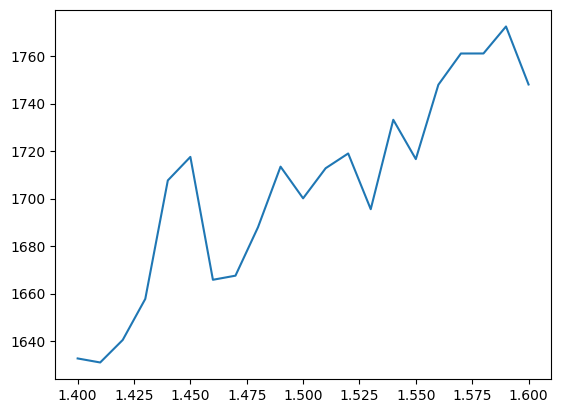

1.58


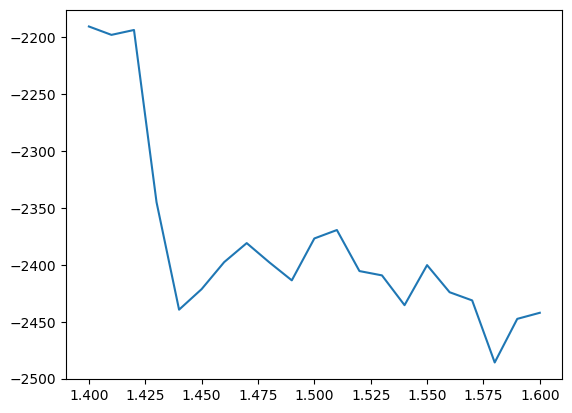

In [8]:
plt.plot(amp_list,I_q1)
plt.show()
min_idx = np.argmin(Q_q1)
best_amp = amp_list[min_idx]
print(best_amp)
plt.plot(amp_list,Q_q1)
plt.show()